<a href="https://colab.research.google.com/github/MehrdadJalali-KIT/Spectrum/blob/main/ActualPredcitedCNN_withNoise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Shape of spectraData: (4095, 1500)
Epoch 1/50
128/128 [==============================] - 6s 30ms/step - loss: 0.2086
Epoch 2/50
128/128 [==============================] - 4s 30ms/step - loss: 0.0813
Epoch 3/50
128/128 [==============================] - 5s 38ms/step - loss: 0.0652
Epoch 4/50
128/128 [==============================] - 4s 29ms/step - loss: 0.0592
Epoch 5/50
128/128 [==============================] - 4s 33ms/step - loss: 0.0560
Epoch 6/50
128/128 [==============================] - 6s 44ms/step - loss: 0.0526
Epoch 7/50
128/128 [==============================] - 4s 30ms/step - loss: 0.0508
Epoch 8/50
128/128 [==============================] - 4s 30ms/step - loss: 0.0485
Epoch 9/50
128/128 [==============================] - 5s 38ms/step - loss: 0.0479
Epoch 10/50
128/128 [==============================] - 4s 30ms/step - loss: 0.0460
Epoch 11/50
128/128 [==============================] - 4s 29ms/step - loss: 0.0448
Epoch 12/50
128/128 [==============================] - 5s 38m

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/32 [==============================] - 0s 8ms/step
   Noise Level      RMSE  R2 Score
0          0.1  0.145886  0.859127
1          0.2  0.158504  0.833515
2          0.5  0.221530  0.673348
3          0.8  0.281120  0.472143
32/32 [==============================] - 0s 8ms/step


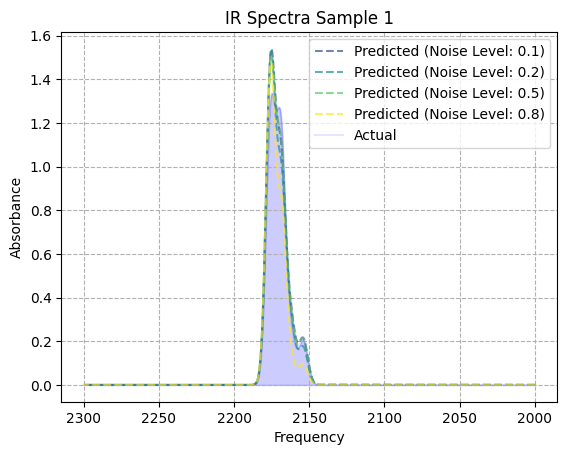

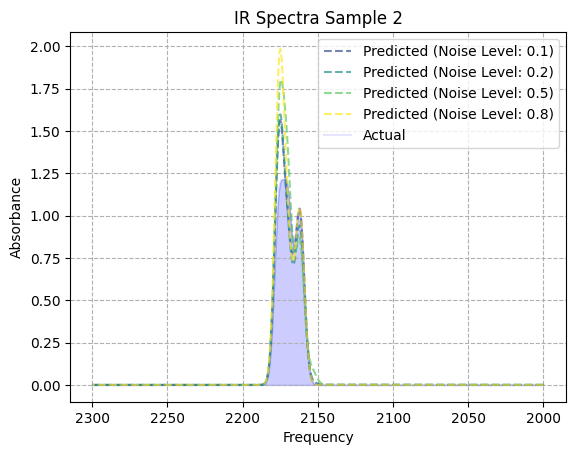

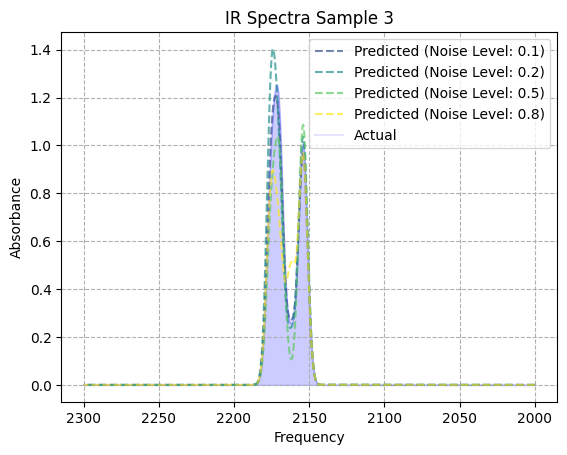

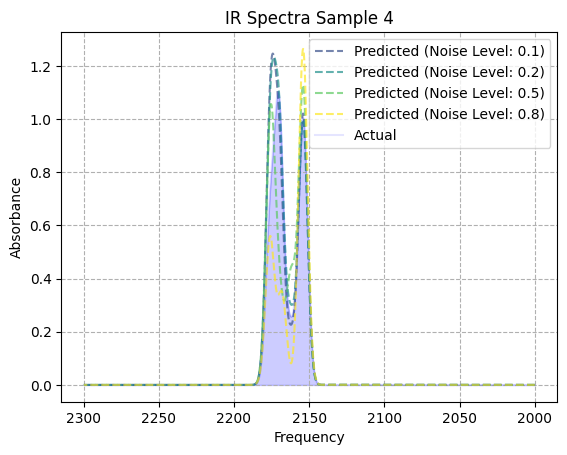

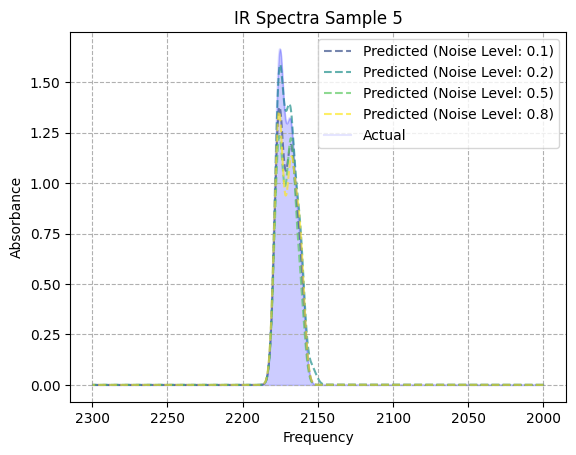

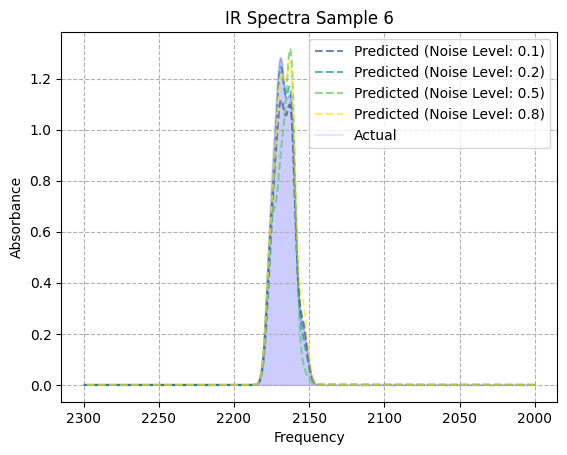

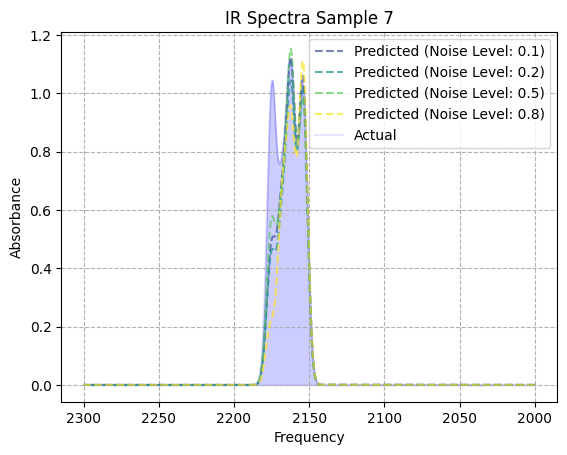

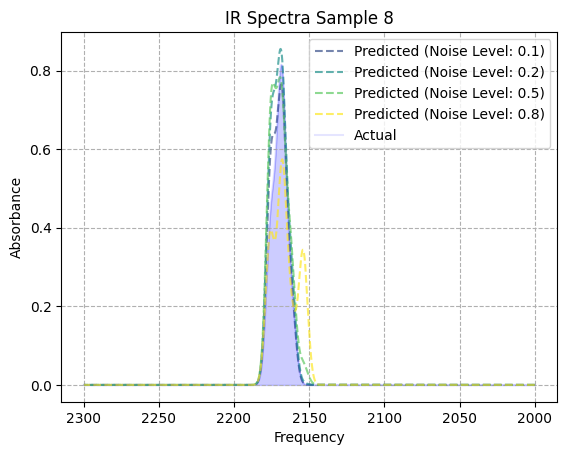

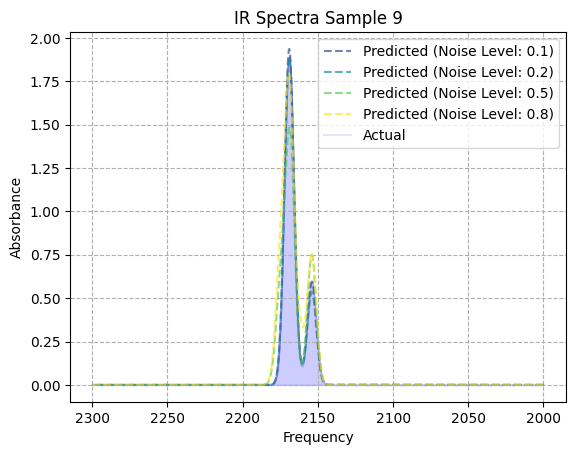

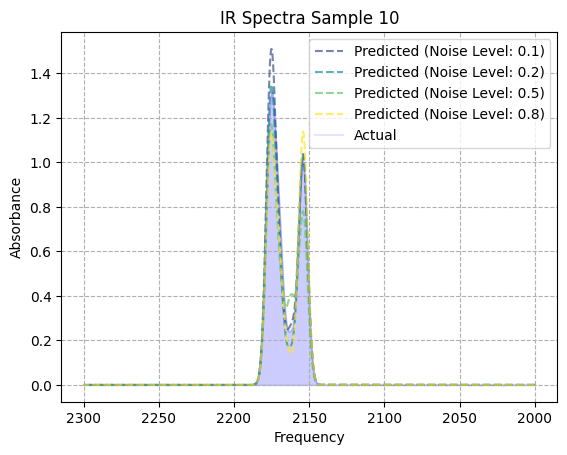

In [56]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten, AveragePooling1D
from tensorflow.keras import regularizers
import random
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import itertools

np.random.seed(56)
random.seed(56)
tf.random.set_seed(56)

# Function to generate a spectrum as a sum of Gaussians
def generate_spectrum_gaussians(amplitudes, centers, x_range):
    widthG = 18
    return np.sum([amplitudes[i] * np.exp(-(x_range - centers[i])**2 / widthG) for i in range(len(centers))], axis=0)

def generate_multiple_spectra(amplitudes, centers):
    widthG = 18
    x_range = np.arange(2300, 2000, -0.2)  # Correct range generation

    all_spectra = []

    for i, center in enumerate(centers):
        if center == 2176:
            intensity_ratios = [5, 2, 1]
            frequencies = [2176, 2168, 2147]
        elif center == 2168:
            intensity_ratios = [3, 1]
            frequencies = [2168, 2147]
        else:
            intensity_ratios = [1]
            frequencies = [center]  # Directly use center if it doesn't match special cases

        # Adjust this line to correctly apply amplitude and intensity ratios
        spectrum = np.sum([amplitudes[i] * np.exp(-(x_range - frequency)**2 / widthG) * intensity_ratio for frequency, intensity_ratio in zip(frequencies, intensity_ratios)], axis=0)
        all_spectra.append(spectrum)

    final_spectrum = np.sum(all_spectra, axis=0)

    return final_spectrum

# Define specific frequencies and corresponding classes/labels
specificFrequencies = {
    2175: 'CeO2(110)red',
    2170: 'CeO2(110)ox',
    2176: 'CeO2(100)ox',
    2168: 'CeO2(100)red',
    2162: 'CeO2(111)red',
    2154: 'CeO2(111)ox'
}

# Define possible amplitudes
possible_amplitudes = [0, 0.2, 0.6, 1.0]

# Generate all possible combinations of amplitudes
amplitude_combinations = list(itertools.product(possible_amplitudes, repeat=len(specificFrequencies)))

# Exclude the combination where all amplitudes are 0.0
amplitude_combinations = [combo for combo in amplitude_combinations if sum(combo) > 0.0]

# Shuffle the amplitude combinations
random.shuffle(amplitude_combinations)

# Generate spectra data with corresponding amplitude vectors
spectraDataAmplitudesList = []
for amplitudes in amplitude_combinations:
    spectrum = generate_multiple_spectra(amplitudes, list(specificFrequencies.keys()))
    spectraDataAmplitudesList.append((spectrum, amplitudes))

# Shuffle the spectra data
random.shuffle(spectraDataAmplitudesList)

# Split the data into spectra and amplitudes
spectraData = np.array([data[0] for data in spectraDataAmplitudesList])
amplitudesData = np.array([data[1] for data in spectraDataAmplitudesList])

print("Shape of spectraData:", spectraData.shape)

num_samples, points_per_spectrum = spectraData.shape
num_specific_frequencies = len(specificFrequencies)
spectraData = np.reshape(spectraData, (num_samples, points_per_spectrum // num_specific_frequencies, num_specific_frequencies))

# Model Parameters
regularization_parameter = 0.0001

# Define the input shape based on spectraData's shape
input_shape = spectraData.shape[1:]

# Create the model
model = Sequential()

# Feature Extraction Part
# Three parallel 1D convolutional layers
for kernel_size in [5, 10, 15]:
    model.add(Conv1D(12, kernel_size, strides=1, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l1(regularization_parameter)))

# Concatenate the outputs of the parallel layers
# Add additional 1D convolutional layers
model.add(Conv1D(12, 15, strides=1, activation='relu', kernel_regularizer=regularizers.l1(regularization_parameter)))
model.add(Conv1D(12, 15, strides=1, activation='relu', kernel_regularizer=regularizers.l1(regularization_parameter)))

# Average Pooling
model.add(AveragePooling1D(pool_size=2, strides=50))

# Flatten the output
model.add(Flatten())

# Quantification Stage
# Fully Connected Layers
model.add(Dense(4000, activation='relu', kernel_regularizer=regularizers.l1(regularization_parameter)))
model.add(Dense(num_specific_frequencies, activation='relu', kernel_regularizer=regularizers.l1(regularization_parameter)))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(spectraData, amplitudesData, epochs=50)

# Save the model
model.save('CNN_Model_systematic.h5')

# Function to generate new spectra data with added noise
def add_noise(spectrum, noise_level):
    noise = np.random.normal(0, noise_level, spectrum.shape)
    return spectrum + noise

# Generate new spectra data for testing
num_new_spectra = 1000
new_spectra_data_amplitudes_list = []
for _ in range(num_new_spectra):
    amplitudes = random.choice(amplitude_combinations)  # Correctly select a random amplitude combination
    spectrum = generate_multiple_spectra(amplitudes, list(specificFrequencies.keys()))
    new_spectra_data_amplitudes_list.append((spectrum, amplitudes))

# Split the new data into spectra and amplitudes
new_spectra_data = np.array([data[0] for data in new_spectra_data_amplitudes_list])
new_amplitudes_data = np.array([data[1] for data in new_spectra_data_amplitudes_list])

num_samples_new, points_per_spectrum_new = new_spectra_data.shape
new_spectra_data = np.reshape(new_spectra_data, (num_samples_new, points_per_spectrum_new // num_specific_frequencies, num_specific_frequencies))

import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

def plot_curves(actual, predicted, specificFrequencies, x_range, noise_levels):
    num_samples = len(actual)

    # Select 10 random samples for plotting
    num_samples_to_plot = min(num_samples, 10)
    selected_indices = np.random.choice(num_samples, num_samples_to_plot, replace=False)

    colors = plt.cm.viridis(np.linspace(0, 1, len(noise_levels) + 1))  # Choose colors from colormap, one extra for the actual curve
    actual_color = 'blue'  # Set actual curve color to blue
    t=0
    for idx in selected_indices:
        plt.figure()

        # Plot predicted curves for different noise levels
        for j, (noise_level, predicted_data) in enumerate(zip(noise_levels, predicted)):
            plt.plot(x_range, predicted_data[idx], linestyle='--', label=f'Predicted (Noise Level: {noise_level})', color=colors[j+1], alpha=0.7)

        # Plot actual curve with fill_between
        plt.plot(x_range, actual[idx], label='Actual', color=actual_color, alpha=0.1)
        plt.fill_between(x_range, actual[idx], color='blue', alpha=0.2)  # Transparent fill between actual and predicted curves

        plt.xlabel('Frequency')
        plt.ylabel('Absorbance')
        plt.grid(True, which="both", ls="--")
        plt.gca().invert_xaxis()  # Invert the x-axis
        plt.legend()
        plt.title(f'IR Spectra Sample {t+1}')
        t=t+1
        plt.show()



# Define noise levels
noise_levels = [0.1, 0.2, 0.5, 0.8]  # Example noise levels

# Create a dictionary to store RMSE and R2 scores for each noise level
scores = {'Noise Level': [], 'RMSE': [], 'R2 Score': []}

for noise_level in noise_levels:
    # Generate new spectra data with noise for testing
    new_spectra_data_noise = np.array([add_noise(spectrum, noise_level) for spectrum in new_spectra_data])

    # Predict amplitudes for the new spectra with noise
    predicted_amplitudes_new_noise = model.predict(new_spectra_data_noise)

    # Calculate RMSE
    rmse_noise = np.sqrt(mean_squared_error(new_amplitudes_data, predicted_amplitudes_new_noise))
    scores['RMSE'].append(rmse_noise)

    # Calculate R2 Score
    r2_noise = r2_score(new_amplitudes_data, predicted_amplitudes_new_noise)
    scores['R2 Score'].append(r2_noise)

    # Add noise level to the scores dictionary
    scores['Noise Level'].append(noise_level)

# Create a table to show RMSE and R2 scores for different noise levels
scores_df = pd.DataFrame(scores)
print(scores_df)

# Create a list to store actual and predicted data for each noise level
actual_to_plot_noise = [[generate_spectrum_gaussians(amplitudes, list(specificFrequencies.keys()), np.arange(2000, 2299.8, 0.2)) for amplitudes in new_amplitudes_data] for _ in noise_levels]
predicted_to_plot_noise = [[generate_spectrum_gaussians(amplitudes, list(specificFrequencies.keys()), np.arange(2000, 2299.8, 0.2)) for amplitudes in model.predict(np.array([add_noise(spectrum, noise_level) for spectrum in new_spectra_data]))] for noise_level in noise_levels]

# Plot actual and predicted curves for selected samples with noise
plot_curves(actual_to_plot_noise[0], predicted_to_plot_noise, specificFrequencies, np.arange(2000, 2299.8, 0.2), noise_levels)
